<a href="https://colab.research.google.com/github/sherylla/UCB_Final_Project/blob/will_barnes/finproj_segment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
'''NOTE THAT THIS WAS MEANT TO BE RUN IN GOOGLE COLLAB - 
IF YOU WOULD LIKE A LINK TO THE NOTEBOOK IN GOOGLE COLLAB, IT IS PASTED BELOW
https://colab.research.google.com/drive/1z7OY51sPc1xl17AQ999G01sGf8PKrBr_?usp=sharing'''

'NOTE THAT THIS WAS MEANT TO BE RUN IN GOOGLE COLLAB - \nIF YOU WOULD LIKE A LINK TO THE NOTEBOOK IN GOOGLE COLLAB, IT IS PASTED BELOW\nhttps://colab.research.google.com/drive/1z7OY51sPc1xl17AQ999G01sGf8PKrBr_?usp=sharing'

Description of the Data:


1. Preliminary Data Preprocessing 

The data was retrieved from a SQL table housed in the cloud via Postgres. 
The data was loaded into Postgres as two separate data frames. 
The data was then converted each into their own  table.
The red wine dataframe was given a new column with a value of 0, while the white dataframe was given a new column with a value of 1, to indicate the type of the wine (red or white).
The data was then combined into a singular dataframe. 
The data was then retrieved in Python.

2. Preliminary Feature Engineering 

There did not need to be any changes to the data types of the features, as they were already numeric. However, I did scale the data using the standard scaler set. 

3. Preliminary feature Selection

I conducted a PCA analysis to find the most accurate model based on the number of components. See below in the analysis for details, but it found that the model was most accurate with nine features, so I used the 9 features. 

4. How data was split into training and testing sets 

The data was split into training and testing sets using stratification, meaning it would mirror the breakdown present in the existing dataset. 

5. Explanation of model choice,

We selected a logistic regression model because we are trying to predict a binary outcome - if the wine is quality or not. 
Additionally, we tried all methods available to increase accuracy - random over/under sampling, SMOTE, SMOTEEN, but all yieleded lower accuracy scores than without, so none should be used. 




In [58]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler



In [21]:
'DATA LOADING'


'DATA LOADING'

In [22]:
connection = psycopg2.connect(
    host = 'dataviz.cnabmkksexqr.us-west-2.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = '    database='amazon_reviews'
    )
cursor=connection.cursor()

In [23]:
sql = """
SELECT *
FROM "Joined_Tables" 
"""
df_combo_raw = pd.read_sql(sql, con=connection)

In [24]:
#sanity check it
df_combo_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine type
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,1
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,1
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,1
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,1
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,1


In [25]:
#check types of data - good, all numbers
df_combo_raw.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine type                 int64
dtype: object

In [26]:
#check for missing values
count_nan = len(df_combo_raw) - df_combo_raw.count()
print(count_nan)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine type               0
dtype: int64


In [27]:
#check for number of quality targets - each wine has a quality score between 3 and 9
df_combo_raw.groupby(['quality']).count().head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur_dioxide,density,pH,sulphates,alcohol,wine type
quality,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30
4,216,216,216,216,216,216,216,216,216,216,216,216
5,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138
6,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836
7,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079
8,193,193,193,193,193,193,193,193,193,193,193,193
9,5,5,5,5,5,5,5,5,5,5,5,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79be8d6f60>]],
      dtype=object)

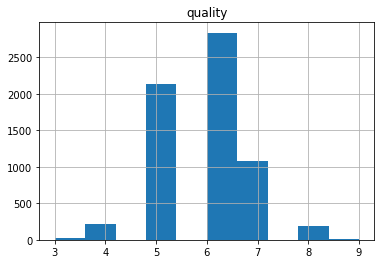

In [28]:
df_combo_raw.hist(column='quality')


In [29]:
# there are too many values for the target. I will change each target to be High Quality, a value of 1, or Low Quality, a value of 0. High quality sits between 7,8,9. Low Quality sits between 3,4,5,6
df_copy = df_combo_raw.copy()
df_copy.loc[(df_copy.quality < 6),'quality']=0
df_copy.loc[(df_copy.quality > 5),'quality']=1

df_copy.groupby(['quality']).count().head(20)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur_dioxide,density,pH,sulphates,alcohol,wine type
quality,,,,,,,,,,,,
0,2384,2384,2384,2384,2384,2384,2384,2384,2384,2384,2384,2384
1,4113,4113,4113,4113,4113,4113,4113,4113,4113,4113,4113,4113


In [30]:
#change the name of the DF for readability
df_combo_cleaned = df_copy        

In [31]:
#scale the data
data_scaler = StandardScaler()
df_combo_scaled = data_scaler.fit_transform(df_combo_cleaned.drop(columns="quality"))
df_combo_scaled

array([[-2.63458886, -0.1802048 , -2.0551926 , ..., -0.61338508,
         1.60000607,  0.57136659],
       [-2.55744824, -0.69653353,  0.55996589, ..., -1.15103964,
         1.9354021 ,  0.57136659],
       [-2.3260264 , -1.0306286 ,  0.28468605, ...,  2.41092186,
         1.26461004,  0.57136659],
       ...,
       [ 6.46800365,  1.85473786,  1.17934553, ...,  1.40281954,
         0.50996897, -1.75018984],
       [ 6.46800365,  2.09771608,  3.03748445, ...,  0.99957862,
         0.59381798, -1.75018984],
       [ 6.6994255 ,  0.12351798,  2.28046489, ...,  2.07488775,
         3.69623127, -1.75018984]])

In [32]:
#check if data is scaled
import numpy as np
print(np.mean(df_combo_scaled[:,0]))
print(np.std(df_combo_scaled[:,0]))

-3.4996717784089895e-16
1.0


In [33]:
'MODEL CREATION'

'MODEL CREATION'

In [34]:
#define target and features
y = df_combo_cleaned["quality"]
X = df_combo_scaled

In [35]:
#train the data set
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)

In [36]:
'''BEGIN SEGMENT TWO: PCA'''
variance_list = [0.95,0.90,0.85,0.80,0.75,0.70]

from sklearn.decomposition import PCA

from sklearn import metrics

benchmark_cols = ['Variance retained','n_Components','Accuracy_percentage']
benchmark = pd.DataFrame(columns = benchmark_cols)

def benchmark_pca(variance,train_img,train_lbl,test_img,test_lbl):
    global benchmark
    print(train_img.shape)
    pca = PCA(variance)
    pca.fit(train_img)
    n_components = pca.n_components_
    train_img = pca.transform(train_img)

    # pca.fit(test_img)
    test_img = pca.transform(test_img)
    logisticRegr = LogisticRegression(solver = 'lbfgs')
    #start = time.time()
    logisticRegr.fit(train_img, train_lbl)
    #end =  time.time()
 
    #timing = end-start   

    # Predict for Multiple Observations (images) at Once
    predicted = logisticRegr.predict(test_img)   

    # generate evaluation metrics
    accuracy = (metrics.accuracy_score(test_lbl, predicted))
    #return 
    a = dict(zip(benchmark_cols,[variance,n_components,accuracy]))
    benchmark = benchmark.append(a,ignore_index=True)

for variance in variance_list:
    benchmark_pca(variance,X_train,y_train,X_test,y_test)

(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)
(4872, 12)


In [37]:
benchmark

,Variance retained,n_Components,Accuracy_percentage
0,0.95,9.0,0.747077
1,0.90,8.0,0.719385
2,0.85,6.0,0.694154
3,0.80,5.0,0.694154
4,0.75,5.0,0.694154
5,0.70,4.0,0.682462


Text(0.5, 1.0, 'no of components vs accuracy')

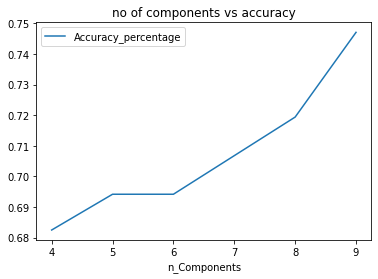

In [38]:
benchmark.plot(x=1,y=-1)
plt.title("no of components vs accuracy")

In [39]:
from sklearn.pipeline import Pipeline
pca = PCA(n_components=9)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.7470769230769231


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[346 250]
 [161 868]]


In [42]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       596
           1       0.78      0.84      0.81      1029

    accuracy                           0.75      1625
   macro avg       0.73      0.71      0.72      1625
weighted avg       0.74      0.75      0.74      1625



In [43]:
'''NOTICING THAT THE MODEL IS NOT AS ACCURATE AT PREDICITING QUALITY WINE (1) AS IT IS POOR WINE (0), GOING TO TRY VARIOUS METHODS OF RESAMPLING BELOW. AS YOU WILL SEE, ALL MADE THE MODEL LESS ACCURATE AND ARE THUS NOT ADVISABLE.'''

'NOTICING THAT THE MODEL IS NOT AS ACCURATE AT PREDICITING QUALITY WINE (1) AS IT IS POOR WINE (0), GOING TO TRY VARIOUS METHODS OF RESAMPLING BELOW. AS YOU WILL SEE, ALL MADE THE MODEL LESS ACCURATE AND ARE THUS NOT ADVISABLE.'

In [44]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [45]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
pca = PCA(n_components=9)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
smote_predictions = pipe.predict(X_test)

In [46]:
#MODEL GETS LESS ACCURATE WITH SMOTE, DO NOT USE RESAMPLE
print(accuracy_score(y_test, smote_predictions))

0.7236923076923077


In [47]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:

#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE
pca = PCA(n_components=9)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
ros_predictions = pipe.predict(X_test)

In [49]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE

print(accuracy_score(y_test, ros_predictions))

0.7206153846153847


In [50]:
#MODEL GETS LESS ACCURATE WITH ROS, DO NOT USE RESAMPLE

report = classification_report(y_test, ros_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       596
           1       0.83      0.70      0.76      1029

    accuracy                           0.72      1625
   macro avg       0.71      0.73      0.71      1625
weighted avg       0.74      0.72      0.73      1625



In [51]:
#MODEL GETS LESS ACCURATE WITH RUS, DO NOT USE RESAMPLE

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [52]:
#MODEL GETS LESS ACCURATE WITH RUS, DO NOT USE RESAMPLE

pca = PCA(n_components=9)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
rus_predictions = pipe.predict(X_test)

In [53]:
#MODEL GETS LESS ACCURATE WITH RUS, DO NOT USE RESAMPLE

print(accuracy_score(y_test, rus_predictions))

0.7212307692307692


In [54]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [55]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE


pca = PCA(n_components=9)
cls = LogisticRegression() 
pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(X_resampled, y_resampled)
cc_predictions = pipe.predict(X_test)

In [56]:
#MODEL GETS LESS ACCURATE WITH CLUSTER CENTROID, DO NOT USE RESAMPLE

print(accuracy_score(y_test, cc_predictions))

0.7163076923076923
